In [1]:
from __future__ import division
import time
from scipy.special import logsumexp  #to deal with potential overflow issues
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import csv

from scipy.misc import imresize # to reduce size of images

%matplotlib inline

class_names = ['tshirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']


def create_submission_file(fname, preds):
    """
    Create Kaggle submision with predictions written as a csv (comma separated values) file 
    """
    
    ofile  = open(fname, "w")
    writer = csv.writer(ofile, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)        
    writer.writerow(['id', 'label'])
    for i in range(preds.shape[0]):
        writer.writerow([i,preds[i]])
        
def read_fMNIST(dataset = "training", path = "./",dim=16):
    """
    reading in the "Fashion MNIST" data
    this function allows specification of the part to be read (training/testing/validation)
    if load_small = True, this will look for the file(s) associated with the small training set
    Note that if dataset='testing', no labels will be returned
    Dimension: dim specifies the target image dimension (default is to reduce images to 16x16)
    """
    
    #Figure out the name of the file to load    
    if dataset.lower() == "training":
        file_name_suffix = 'Tr'
        has_labels = True
    
    elif dataset.lower() == "validation":
        file_name_suffix = 'Vl'
        has_labels = True

    elif dataset.lower() == "testing":
        file_name_suffix = 'Te'
        has_labels = False

    else:
        print("dataset must be 'testing','validation', or 'training'")
        raise ValueError
    
    #Load the appropriate files
    X = np.load('./x'+file_name_suffix+'.npy')
    if has_labels:
        y = np.load('./y'+file_name_suffix+'.npy')
    
    X = reduceImg(X,dim)
    
    #Return the appropriate data
    if has_labels:
        return X,y
    else:
        return X
         
            
def showImage(image,ax=None):
    """
    Render a given numpy.uint8 2D array of pixel data.
    """
    if len(image.shape) > 1:
        n=image.shape[0]
    else:
        n=int(np.sqrt(image.shape[0]))
        image = image[-n**2:]
        image = image.reshape(n,n)

    
    if ax==None:
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    plt.axis('off')
    

def reduceImg(X,dnew):
    # image size in X is hardcoded = 28 (not best practice!)
    xNew=np.zeros((X.shape[0],dnew*dnew))
    for i in range(X.shape[0]):
        xNew[i]=imresize(X[i].reshape(28,28),(dnew,dnew),'bicubic').flatten()
    return xNew

In [2]:
# Load training data
xTrain, yTrain = read_fMNIST('training')
# Load validation data
xVal, yVal = read_fMNIST('validation')

# scale pixel values to [0,1] to make things better-behaved numerically
xTrain=xTrain/255
xVal=xVal/255

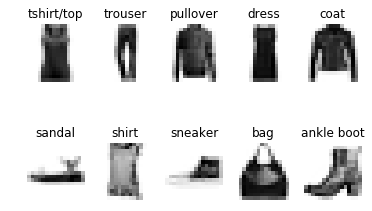

In [3]:
for c in range(10):
    ax=plt.subplot(2,5,c+1)
    ax.clear()
    idx = np.argmax(np.argmax(yTrain,axis=1)==c)
    showImage(xTrain[idx],ax)
    ax.set_title(class_names[c])
    


In [4]:
# We need a function to get likelihood of multi-variate gaussian
def multiGauss(X, mu, sigma, nf):
    """
    Multivariate Gaussian density function
    
    """
    sigma_inv = np.linalg.inv(sigma)
    _, sigma_det = np.linalg.slogdet(sigma)
    
    shifted_data = X - mu


    shifted_data_sigma_mul = np.sum(np.multiply(np.dot(shifted_data, sigma_inv), shifted_data), axis=1)
    
    return -0.5 * (nf * np.log(2*np.pi) + sigma_det + shifted_data_sigma_mul)

In [7]:
class GaussianMixtureModel(object):
    """Gaussian Mixture Model"""
    
    def __init__(self, X, num_comp, max_iter=50, eps=10**(-7), cov_type='diag'):
        """Initialize the GMM model.
        num_feat: Feature dimension of our data
        num_comp: Number of components to fit in the mixture model.
        max_iter: Maximum number of EM iterations.
        cov_type: Type of covariance matrix used by multivariate Gaussian models ('diag': diagonal, otherwise full)
        """
        self.nf = X.shape[1]
        self.nc = num_comp
        self.max_iter = max_iter
        self.eps = 0.00001
        self.cov_type = cov_type
        
        # Initialization: feel free to improve this.
        # Note that we are passing the data X so you can use it to try smarter init strategies
        
        # initialize mixing prob to be uniform
        self.pi = np.repeat(1.0/self.nc, self.nc)
        # initialize means to random (Gaussian) vectors

        #self.mu=np.random.uniform(0,1,((self.nc,self.nf)))  #np.zeros((self.nc,self.nf))
        self.mu = np.zeros((self.nc,self.nf))
        for c in range(self.nc):
            self.mu[c] = np.mean(X[np.random.randint(X.shape[0], size=10), :], axis = 0)
        self.sigma=np.zeros((self.nc,self.nf,self.nf))
        # initialize covariances to I_nf (identity)
        for c in range(self.nc):
            self.sigma[c]=np.eye(self.nf) 
        

    def Estep(self, X):
        """Update the soft weights and calculate likelihood in the process."""
        log_gamma = np.zeros((X.shape[0], self.nc))
        
        log_pi = np.log(self.pi)
        for comp in range(self.nc): # calculate weighted density for each component
            l = log_pi[comp] + multiGauss(X, self.mu[comp], self.sigma[comp], self.nf)
            log_gamma[:, comp] = l    
            
        
        # now you can use the values of log_gamma to calculate log-likelihood, responsibilities, etc
        log_prob_per_instance = logsumexp(log_gamma, axis=1, keepdims=True)
        log_likelihood = np.mean(log_prob_per_instance)
        gamma = np.exp(log_gamma - log_prob_per_instance)  # note that this will compute actual responsibilities
        return gamma, log_likelihood, log_prob_per_instance
        
        
    def Mstep(self, X, gamma):
        """Update the model params given the soft weights."""
        # Calculate unnormalized pi with epsilon added to avoid cases where a component gets no instances
        unnorm_pi = np.sum(gamma, axis=0) + self.eps # shape = (nc,);
        # Update the overall soft assignments to different components
        self.pi = unnorm_pi/np.sum(unnorm_pi)
        
        for comp in range(self.nc): # update parameters for each component
            # Scale the different instances by the soft weight for the current component
            resp_data = np.dot(np.diag(gamma[:, comp]), X)
            # Normalize the responsible data by total soft weight to get mean
            self.mu[comp] = np.sum(resp_data, axis=0)/unnorm_pi[comp]
            
            shift_data = X - self.mu[comp]   # x - mu
            # Captures the multiplication of gamma in covariance calculation
            resp_scaled_shift_data = np.dot(np.diag(gamma[:, comp]), shift_data)
            
            if self.cov_type == 'diag':
                # Assume that the covariance matrices are diagonal for ease of computation
                # gamma_ik * (x_ij - mu_kj)**2 / sum_i gamma_ik   
                # remember to guard against collapse (sigmas too close to zero)
                sigma_vector = np.diag(np.dot(shift_data.T, resp_scaled_shift_data)/unnorm_pi[comp])
                sigma_length = sigma_vector.shape[0]
                # Preventing collapse if sigma < eps, then S + I *self.eps
                new_sigma = np.diag(sigma_vector)
                minimum = np.amin(new_sigma)
                dim = new_sigma.shape[0]
                if minimum < self.eps:
                    self.sigma[comp] = new_sigma + np.eye(dim) * self.eps
                else:
                    self.sigma[comp] = new_sigma

                
            else:
                # Do the full rank covariance matrix calculation 
                # here, too, you need to consider some protection against collapsing covariance matrices   
                cov_matrix = np.dot(shift_data.T, resp_scaled_shift_data)/unnorm_pi[comp]
                dim = cov_matrix.shape[0]
                new_cov = np.zeros((dim, dim))
                minimum = np.amin(cov_matrix)
                if minimum < self.eps:
                    self.sigma[comp] = cov_matrix + np.eye(dim) * self.eps
                else:
                    self.sigma[comp] = cov_matrix


    
    def train(self, X,verbose='final'):
        """Train the model using EM."""
        prev_likelihood = -np.inf  # Keep track of previous log likelihood
        gamma, log_likelihood, _ = self.Estep(X)  
        for i in range(self.max_iter):
            self.Mstep(X, gamma)  # M-step
            gamma, log_likelihood, _ = self.Estep(X)  
            if np.isclose(log_likelihood,prev_likelihood):
                # Convergence = no significant increase in likelihood after an iteration.
                # Feel free to try other stopping criteria
                break
            else:
                prev_likelihood = log_likelihood
            if verbose == 'iter':
                print ("   Iteration: %d, log-likelihood: %.4f" %(i, log_likelihood))
            
        if verbose == 'final':
                print ("Iteration %d (final), log-likelihood: %.4f" %(i, log_likelihood))
                
                
    def trainFast(self,X,verbose='final',rs=[.03,.1,.3,1]):
        """
        Train the model using EM, gradually fitting larger portion of the data
        rs specifies the fractions of the full data set size to use
        Note: by making the last elements of rs less than 1 you can effectively train on a subset of data
        (examples past the first r*X.shape[0] won't be seen at all)
        """
        for r in rs:
            self.train(X[0:int(np.floor(X.shape[0]*r))],verbose='final')
        

In [8]:
# organize data by class
classData=dict()
for y in range(10):
    classData[y]=xTrain[np.argmax(yTrain,axis=1)==y]


In [9]:
def get_accuracy(models, X,y):
    """
    Compute accuracy of the GMM generative model on (X,y).
    model[c] is the GMM for class c
    Returns (acc, yhat) where yhat are the predictions (in label form)
    """
    total_data = 0.0
    correct = 0.0
    C = len(models)
    N = X.shape[0]
    logLik = np.zeros((N,C))
    for c in range(C):
        _,_, ll_class = models[c].Estep(X)
        logLik[:,c] = np.squeeze(ll_class)
    yhat = np.argmax(logLik,axis=1)
    acc = np.mean(yhat==np.argmax(y,axis=1))
    return acc, yhat




In [10]:
def showMeans(gmmModels,c,handles=False):
    """
    Display means for Gaussian components of gmmModels for class c
    """
    k = mmodels[c].nc
    fig,axes = plt.subplots(1,k)
    
    for j in range(k):
        if k==1:
            ax=axes
        else:
            ax=axes[j]
        showImage(gmmModels[c].mu[j],ax)
        ax.axis('off')
        if j==0:
            ax.set_title(class_names[c]+'/'+str(j))
        else:
            ax.set_title('/'+str(j))
    if handles:
        return fig,axes

## Diagonal Covariance Matrix with 3 Gaussians

0
Iteration 10 (final), log-likelihood: 344.1324
Iteration 3 (final), log-likelihood: 339.1722
Iteration 20 (final), log-likelihood: 346.0820
================ class 0(tshirt/top), mixture of 3 diag Gaussians
1
Iteration 10 (final), log-likelihood: 658.8211
Iteration 5 (final), log-likelihood: 656.2564
Iteration 5 (final), log-likelihood: 650.7453
================ class 1(trouser), mixture of 3 diag Gaussians
2
Iteration 17 (final), log-likelihood: 283.2080
Iteration 2 (final), log-likelihood: 282.1662
Iteration 6 (final), log-likelihood: 277.4046
================ class 2(pullover), mixture of 3 diag Gaussians
3
Iteration 12 (final), log-likelihood: 499.8027
Iteration 15 (final), log-likelihood: 497.1188
Iteration 9 (final), log-likelihood: 495.5753
================ class 3(dress), mixture of 3 diag Gaussians
4
Iteration 10 (final), log-likelihood: 332.8728
Iteration 7 (final), log-likelihood: 338.1995
Iteration 4 (final), log-likelihood: 332.9937
================ class 4(coat), mixture

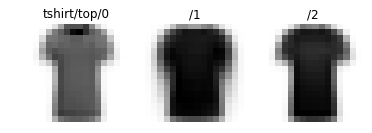

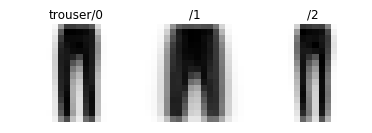

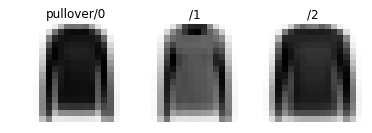

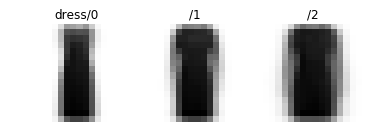

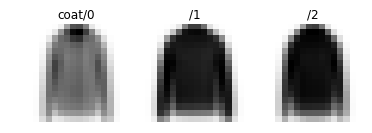

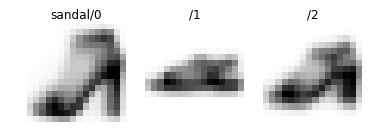

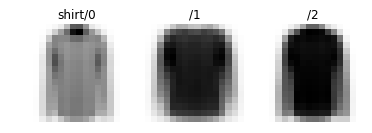

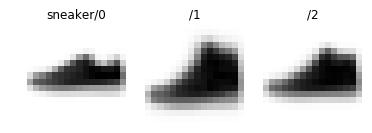

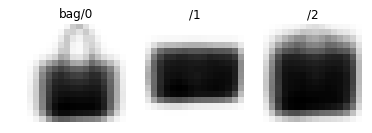

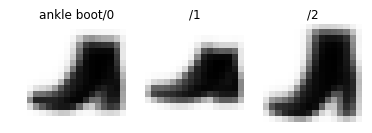

In [11]:
ks=[3]
gmmacc=dict()
gmmaccTrain=dict()

for k in ks:
    mmodels=dict()
    
    for y in range(10):
        print(y)
        mmodels[y] = GaussianMixtureModel(classData[y], k, max_iter=40, cov_type='diag')
        mmodels[y].trainFast(classData[y],verbose='final',rs=[.1,.25,1])
        print('================ class '+str(y)+'('+class_names[y]+'), mixture of %d diag Gaussians'%k)
        
    gmmacc[k], _ = get_accuracy(mmodels,xVal,yVal)
    gmmaccTrain[k], _ = get_accuracy(mmodels,xTrain,yTrain)
    print('GMM-diag (%d) accuracy:  %.4f  [ %.4f on train]'%(k,gmmacc[k],gmmaccTrain[k]))
    for y in range(10):
        showMeans(mmodels,y)
        plt.show()

## Full Covariance Matrix with 3 Gaussians

0
Iteration 3 (final), log-likelihood: 903.1723
Iteration 21 (final), log-likelihood: 580.0435
Iteration 9 (final), log-likelihood: 561.3190
================ class 0(tshirt/top), mixture of 3 full Gaussians
1
Iteration 4 (final), log-likelihood: 973.7948
Iteration 6 (final), log-likelihood: 845.2367
Iteration 8 (final), log-likelihood: 815.8800
================ class 1(trouser), mixture of 3 full Gaussians
2
Iteration 3 (final), log-likelihood: 916.2490
Iteration 16 (final), log-likelihood: 594.3971
Iteration 17 (final), log-likelihood: 564.8096
================ class 2(pullover), mixture of 3 full Gaussians
3
Iteration 3 (final), log-likelihood: 907.2455
Iteration 14 (final), log-likelihood: 662.9874
Iteration 7 (final), log-likelihood: 633.9310
================ class 3(dress), mixture of 3 full Gaussians
4
Iteration 3 (final), log-likelihood: 910.2454
Iteration 22 (final), log-likelihood: 626.3465
Iteration 7 (final), log-likelihood: 576.6942
================ class 4(coat), mixture o

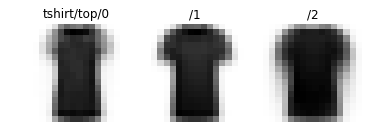

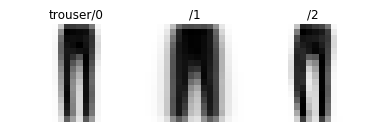

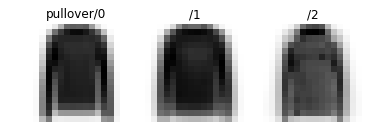

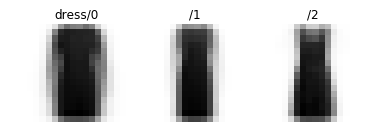

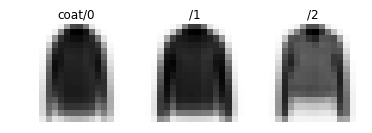

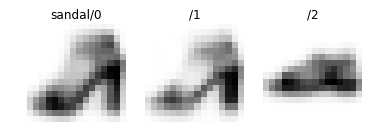

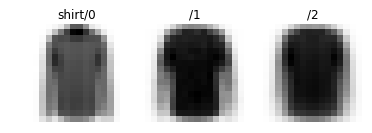

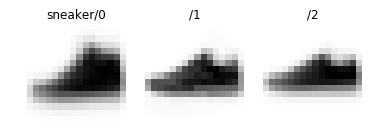

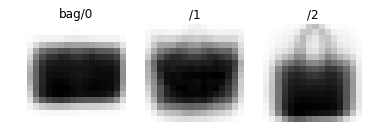

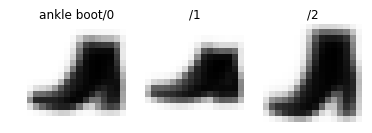

In [12]:
ks=[3]
gmmacc=dict()
gmmaccTrain=dict()

for k in ks:
    mmodels=dict()
    
    for y in range(10):
        print(y)
        mmodels[y] = GaussianMixtureModel(classData[y], k, max_iter=30, cov_type='full')
        mmodels[y].trainFast(classData[y],verbose='final',rs=[.05,.25,1])
        print('================ class '+str(y)+'('+class_names[y]+'), mixture of %d full Gaussians'%k)
        
    gmmacc[k], _ = get_accuracy(mmodels,xVal,yVal)
    gmmaccTrain[k], _ = get_accuracy(mmodels,xTrain,yTrain)
    print('GMM-full (%d) accuracy:  %.4f  [ %.4f on train]'%(k,gmmacc[k],gmmaccTrain[k]))
    for y in range(10):
        showMeans(mmodels,y)
        plt.show()

## Full Covariance Matrix with 12 Gaussians

0
Iteration 4 (final), log-likelihood: 1023.2248
Iteration 5 (final), log-likelihood: 583.5810
Iteration 20 (final), log-likelihood: 536.5973
================ class 0(tshirt/top), mixture of 12 full Gaussians
1
Iteration 4 (final), log-likelihood: 1074.8918
Iteration 5 (final), log-likelihood: 883.9277
Iteration 26 (final), log-likelihood: 835.8595
================ class 1(trouser), mixture of 12 full Gaussians
2
Iteration 5 (final), log-likelihood: 1087.8967
Iteration 11 (final), log-likelihood: 710.5878
Iteration 8 (final), log-likelihood: 593.6274
================ class 2(pullover), mixture of 12 full Gaussians
3
Iteration 4 (final), log-likelihood: 1035.9458
Iteration 14 (final), log-likelihood: 708.6668
Iteration 23 (final), log-likelihood: 676.2900
================ class 3(dress), mixture of 12 full Gaussians
4
Iteration 3 (final), log-likelihood: 1068.4272
Iteration 6 (final), log-likelihood: 683.3374
Iteration 17 (final), log-likelihood: 587.9699
================ class 4(coat),

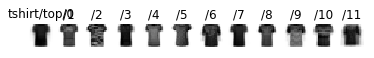

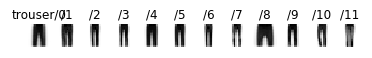

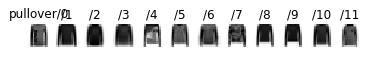

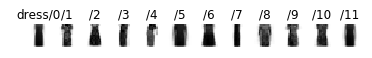

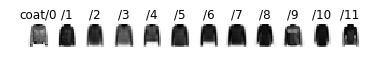

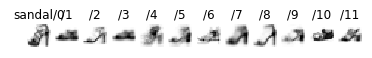

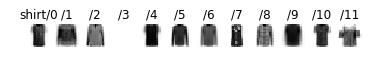

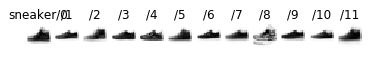

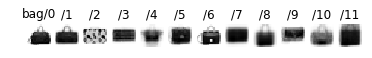

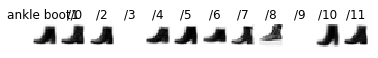

In [13]:
ks=[12]
gmmacc=dict()
gmmaccTrain=dict()

for k in ks:
    mmodels=dict()
    
    for y in range(10):
        print(y)
        mmodels[y] = GaussianMixtureModel(classData[y], k, max_iter=30, cov_type='full')
        mmodels[y].trainFast(classData[y],verbose='final',rs=[.05,.25,1])
        print('================ class '+str(y)+'('+class_names[y]+'), mixture of %d full Gaussians'%k)
        
    gmmacc[k], _ = get_accuracy(mmodels,xVal,yVal)
    gmmaccTrain[k], _ = get_accuracy(mmodels,xTrain,yTrain)
    print('GMM-full (%d) accuracy:  %.4f  [ %.4f on train]'%(k,gmmacc[k],gmmaccTrain[k]))
    for y in range(10):
        showMeans(mmodels,y)
        plt.show()

## BEST MODEL

In [14]:
best_model = mmodels

In [15]:
def get_predictions(models, X, y=None):
    """
    Compute accuracy of the GMM generative model on (X,y).
    model[c] is the GMM for class c
    Returns (acc, yhat) where yhat are the predictions (in label form)
    """
    C = len(models)
    N = X.shape[0]
    
    logLik = np.zeros((N,C))
    
    for c in range(C):
        _,_, ll_class = models[c].Estep(X)
        logLik[:, c] = np.squeeze(ll_class)
    
    yhat = np.argmax(logLik, axis=1)
    
    if y:
        acc = np.mean(yhat==np.argmax(y, axis=1))
        return acc, yhat
    else:
        return yhat

In [16]:
xTe = read_fMNIST('testing')/255
#xTe = preprocess_data(xTe,mu,sigma,visualize=False)
preds = get_predictions(best_model, xTe)
create_submission_file("kaggle-submission.csv", preds)

# 2.2 Quadratic Discriminative Analysis

## Problem 5 : One Gaussian, Full Covariance Matrix for Each Class

0
Iteration 1 (final), log-likelihood: 620.8047
Iteration 1 (final), log-likelihood: 473.1816
Iteration 1 (final), log-likelihood: 443.6280
================ class 0(tshirt/top), mixture of 1 full Gaussians
1
Iteration 1 (final), log-likelihood: 842.6309
Iteration 1 (final), log-likelihood: 756.5585
Iteration 1 (final), log-likelihood: 703.9348
================ class 1(trouser), mixture of 1 full Gaussians
2
Iteration 1 (final), log-likelihood: 637.4554
Iteration 1 (final), log-likelihood: 509.1522
Iteration 1 (final), log-likelihood: 477.3404
================ class 2(pullover), mixture of 1 full Gaussians
3
Iteration 1 (final), log-likelihood: 671.5879
Iteration 1 (final), log-likelihood: 570.0892
Iteration 1 (final), log-likelihood: 539.9084
================ class 3(dress), mixture of 1 full Gaussians
4
Iteration 1 (final), log-likelihood: 629.3900
Iteration 1 (final), log-likelihood: 542.1496
Iteration 1 (final), log-likelihood: 511.9470
================ class 4(coat), mixture of 1 f

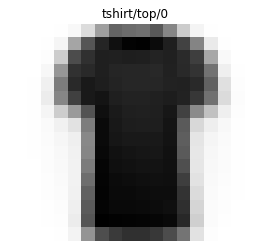

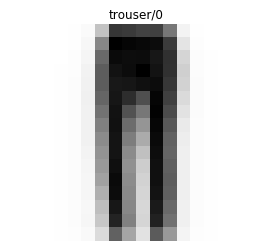

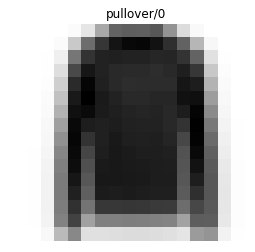

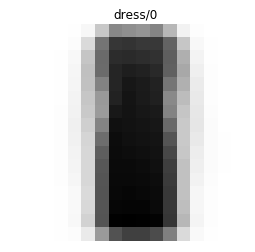

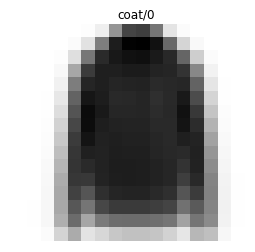

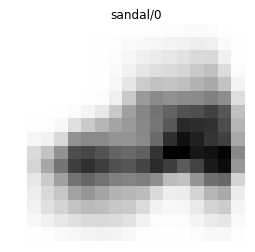

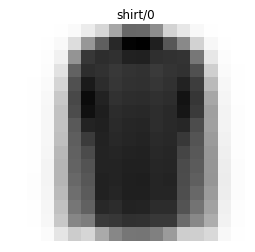

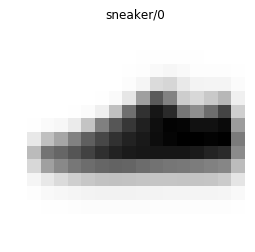

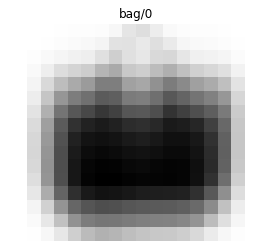

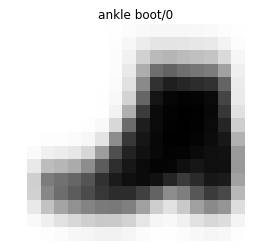

In [17]:
ks=[1]
gmmacc=dict()
gmmaccTrain=dict()

for k in ks:
    mmodels=dict()
    
    for y in range(10):
        print(y)
        mmodels[y] = GaussianMixtureModel(classData[y], k, max_iter=30, cov_type='full')
        mmodels[y].trainFast(classData[y],verbose='final',rs=[.05,.25,1])
        print('================ class '+str(y)+'('+class_names[y]+'), mixture of %d full Gaussians'%k)
        
    gmmacc[k], _ = get_accuracy(mmodels,xVal,yVal)
    gmmaccTrain[k], _ = get_accuracy(mmodels,xTrain,yTrain)
    print('QDA-full (%d) accuracy:  %.4f  [ %.4f on train]'%(k,gmmacc[k],gmmaccTrain[k]))
    for y in range(10):
        showMeans(mmodels,y)
        plt.show()

## Problem 6: Naive Bayes

In this case, the Naive Bayes assumption implies that the training examples $x_i$ for i = 1 . . . n are actually i.i.d. samples from a distribution specified by a Naive Bayes model.

We know from the problem that $p(x_j| y)$ is Gaussian. Therefore, we can train this Naive Bayes model with our EM-algorithm fitting a Gaussin for each class and specifying a diagonal Covariance Matrix that reflects the independence between our features.



0
Iteration 1 (final), log-likelihood: 154.5546
Iteration 1 (final), log-likelihood: 134.4988
Iteration 1 (final), log-likelihood: 133.4159
================ class 0(tshirt/top), mixture of 1 diag Gaussians
1
Iteration 1 (final), log-likelihood: 368.0454
Iteration 1 (final), log-likelihood: 379.7805
Iteration 1 (final), log-likelihood: 319.0658
================ class 1(trouser), mixture of 1 diag Gaussians
2
Iteration 1 (final), log-likelihood: 141.9967
Iteration 1 (final), log-likelihood: 139.8181
Iteration 1 (final), log-likelihood: 131.2353
================ class 2(pullover), mixture of 1 diag Gaussians
3
Iteration 1 (final), log-likelihood: 293.2881
Iteration 1 (final), log-likelihood: 262.6770
Iteration 1 (final), log-likelihood: 274.1505
================ class 3(dress), mixture of 1 diag Gaussians
4
Iteration 1 (final), log-likelihood: 206.5252
Iteration 1 (final), log-likelihood: 211.6725
Iteration 1 (final), log-likelihood: 203.7883
================ class 4(coat), mixture of 1 d

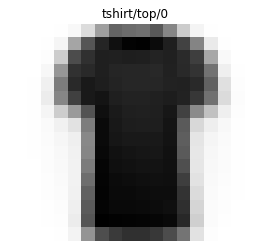

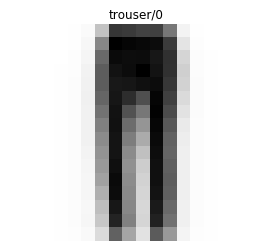

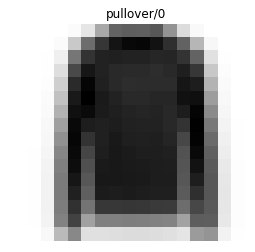

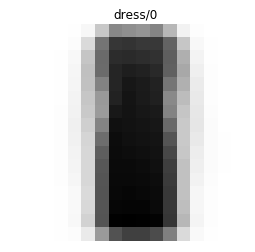

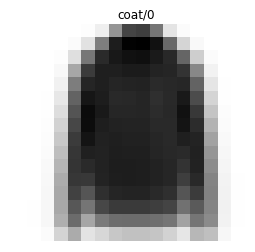

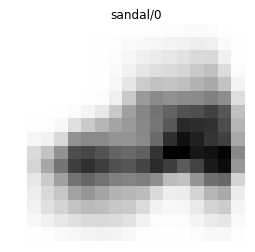

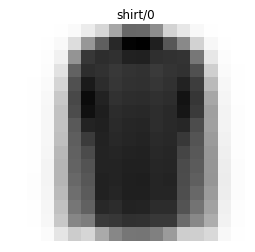

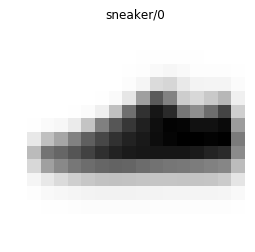

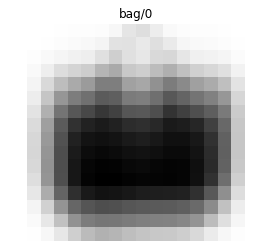

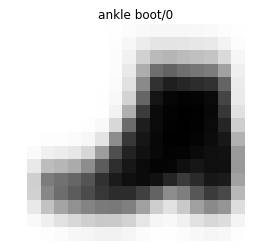

In [18]:
ks=[1]
gmmacc=dict()
gmmaccTrain=dict()

for k in ks:
    mmodels=dict()
    
    for y in range(10):
        print(y)
        mmodels[y] = GaussianMixtureModel(classData[y], k, max_iter=40, cov_type='diag')
        mmodels[y].trainFast(classData[y],verbose='final',rs=[.1,.25,1])
        print('================ class '+str(y)+'('+class_names[y]+'), mixture of %d diag Gaussians'%k)
        
    gmmacc[k], _ = get_accuracy(mmodels,xVal,yVal)
    gmmaccTrain[k], _ = get_accuracy(mmodels,xTrain,yTrain)
    print('NB-diag (%d) accuracy:  %.4f  [ %.4f on train]'%(k,gmmacc[k],gmmaccTrain[k]))
    for y in range(10):
        showMeans(mmodels,y)
        plt.show()

## Problem 7

I decided to change the initilization values for the mean. Instead of drawing random values from a uniform distribution I took random samples with replacement from the set of features an average them. I have as many sample means as number of components.

This strategy improved marginally the results for the accuracy on the validation set for the models with 3 Gaussians with diagonal and full covariance, respectively.

Therefore, an additional strategy was to increase the number of Gaussians to 12 and allow for correlation between the different features by using a full covariance matrix.

This strategy, together with the new initilization strategy, provided better results in terms of accuracy.
The accuracy on the validation set for this model was 0.7910

Things to do:
- fill in the code to run the training above
- use the code to also run QDA and Naive Bayes experiments
- decide on any improvements/extensions, and try them out
- settle on the best overall generative model, and compute and save test prediction (below)